In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from random import randint, shuffle
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['RUL_test.csv', 'submission.csv', 'test_data', 'train_data']


# **Load tain and test Datasets**

In [19]:
df_train = pd.read_csv('input/train_data/train_data.csv', sep=',')
df_test = pd.read_csv('input/test_data/test_data.csv', sep=',')

In [20]:
df_train.head()

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,RUL
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,...,84.93,14.35,8.4712,NaN,NaN,NaN,NaN,NaN,NaN,339
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,...,100.00,14.88,8.9928,NaN,NaN,NaN,NaN,NaN,NaN,338
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,...,84.93,14.21,8.5107,NaN,NaN,NaN,NaN,NaN,NaN,337
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,...,100.00,10.63,6.4578,NaN,NaN,NaN,NaN,NaN,NaN,336
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,...,100.00,14.95,9.0279,NaN,NaN,NaN,NaN,NaN,NaN,335


# **Train a classifier**

### Split train - eval 

In [6]:
list_engine_no = list(df_train['engine_no'].drop_duplicates())

ratio = .3
shuffle(list_engine_no)
engine_no_test = list_engine_no[:int(len(list_engine_no) * ratio)]
engine_no_train = [x for x in list_engine_no if x not in engine_no_test]

In [7]:
nan_column = df_train.columns[df_train.isna().any()].tolist()
const_columns = [c for c in df_train.columns if len(df_train[c].drop_duplicates()) <= 2]
print('Columns with all nan: \n' + str(nan_column) + '\n')
print('Columns with all const values: \n' + str(const_columns) + '\n')

Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']

Columns with all const values: 
['op_setting_3', 'sensor_16', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']



In [8]:
metadata_columns = ['engine_no', 'time_in_cycles']
selected_features = [x for x in df_test.columns if x not in metadata_columns + nan_column + const_columns]

In [9]:
df_train_train = df_train[df_train['engine_no'].isin(engine_no_train)]
data_eval = df_train[df_train['engine_no'].isin(engine_no_test)]

X_train_train, y_train_train = df_train_train[selected_features], df_train_train['RUL'] 
X_eval, y_eval = data_eval[selected_features], data_eval['RUL']

X_train_all, y_train_all = df_train[selected_features], df_train['RUL']

X_test = df_test[selected_features]


### Train the classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=20)
tree.fit(X_train_train, y_train_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Check Overfitting

In [11]:
print("Score on train data : " + str(tree.score(X_train_train, y_train_train)))
print("Score on eval data : " + str(tree.score(X_eval, y_eval)))

Score on train data : 0.22045456560873306
Score on eval data : 0.016935619431837284


### Train on all dataset

In [12]:
tree.fit(X_train_all, y_train_all)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Make the prediction

In [13]:
df_train['pred_tree'] = tree.predict(X_train_all)
df_test['pred_tree'] = tree.predict(X_test)

### Make the decision

In [14]:
df_train = df_train.sort_values(['engine_no', 'time_in_cycles'])
df_test = df_test.sort_values(['engine_no', 'time_in_cycles'])

# On prend la dernière prédiction du RUL
df_result = df_test.groupby('engine_no').last().reset_index()[['engine_no', 'pred_tree']]

# On convertit en binaire (RUL > 100 ?)
df_result['result'] = df_result['pred_tree'].map(lambda x: 0 if x > 100 else 1)


### Plotting the results

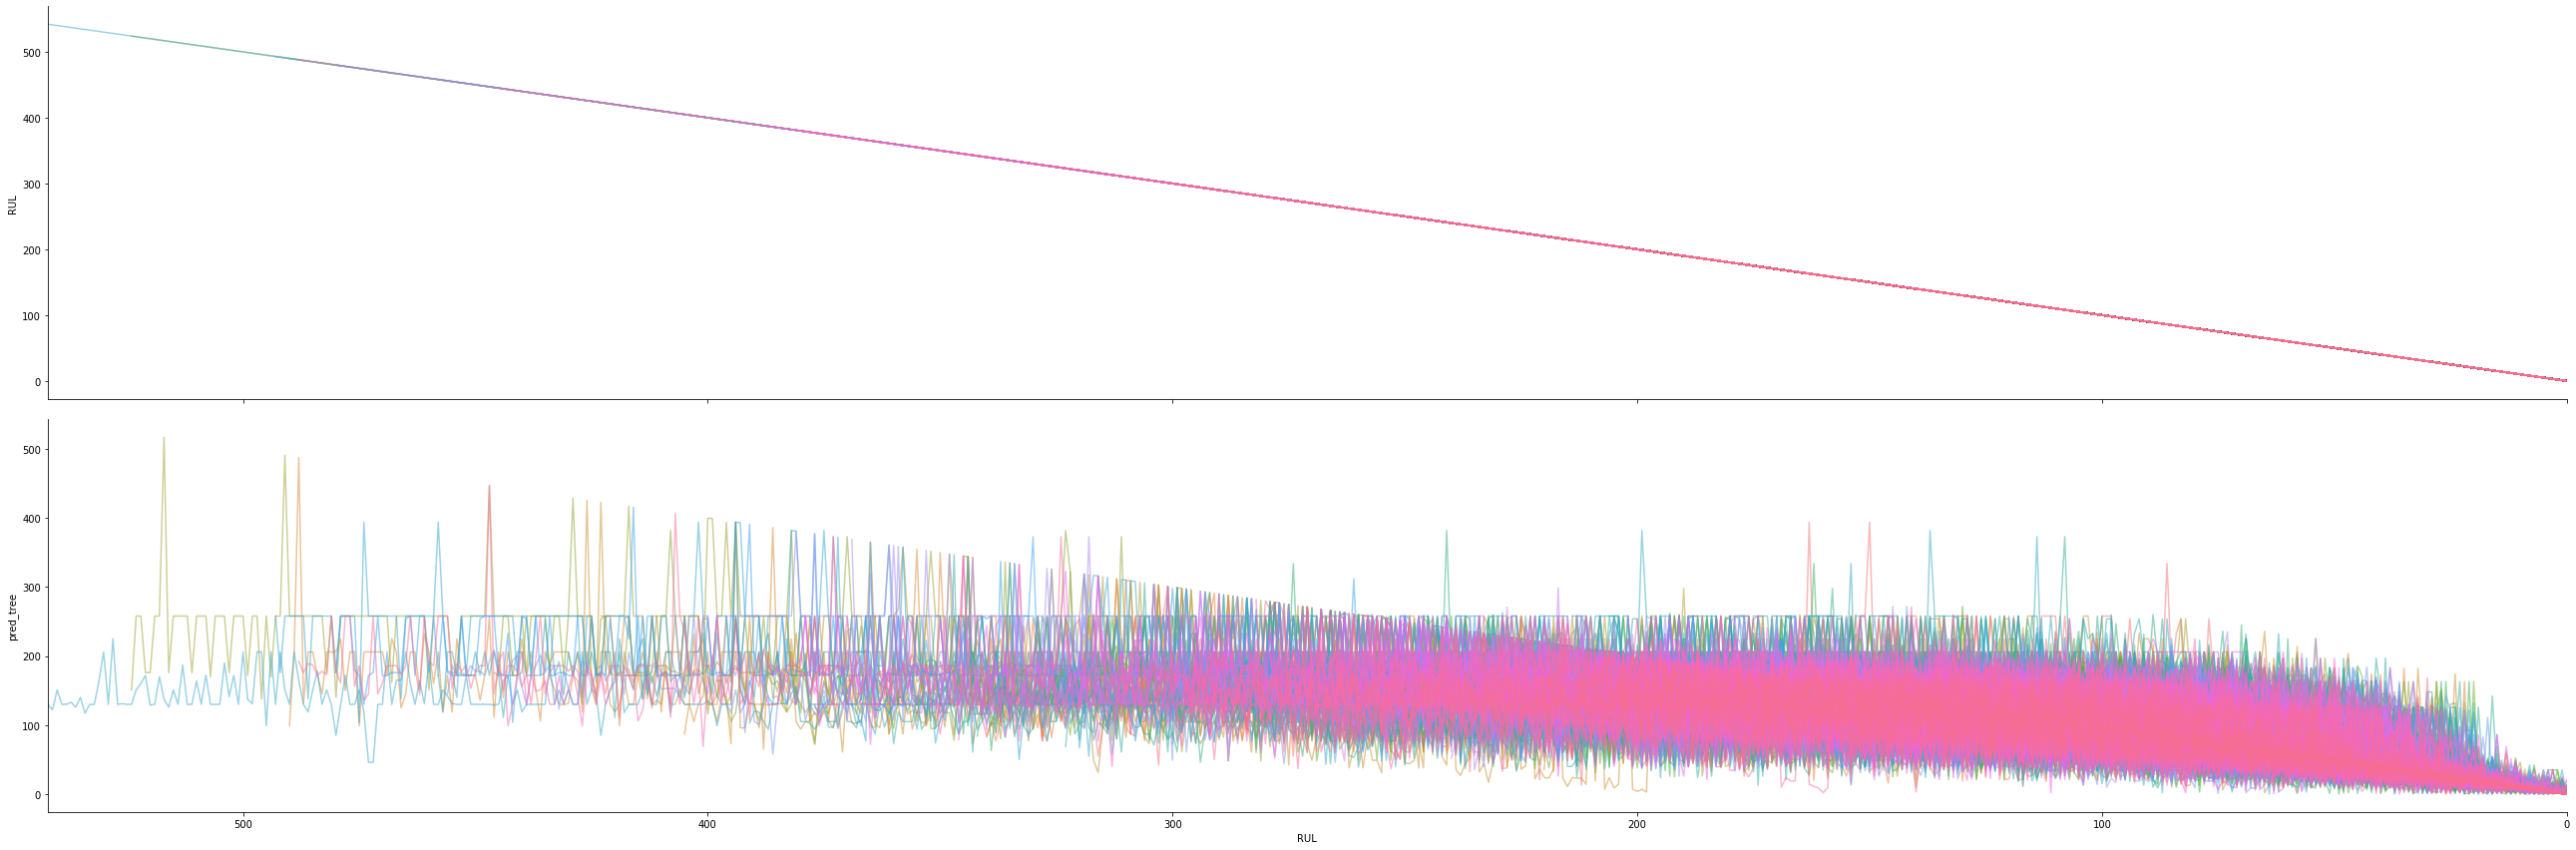

In [15]:
df_plot = df_train.copy()
df_plot = df_plot.sort_values(['engine_no', 'time_in_cycles'])
g = sns.PairGrid(data=df_plot, x_vars="RUL", y_vars=['RUL', 'pred_tree'], hue="engine_no", height=6, aspect=6,)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(df_plot['RUL'].max(),df_plot['RUL'].min()))

### Save the results

In [16]:
df_result[['engine_no', 'result']].to_csv('submission.csv', index=False)